In [33]:
import scanpy as sc
import pandas as pd 
import numpy as np
from anndata import AnnData

In [25]:
import jax.numpy as jnp

In [ ]:
import cellrank as cr
import scvelo as scv

In [2]:
from moscot.problems.time import TemporalNeuralProblem

2023-01-03 11:06:21.180274: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 11:06:21.456685: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 11:06:21.467372: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 11:06:22.671815: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 11:06:22.672654: W external/org

In [3]:
path = "/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad"

In [4]:
adata = sc.read(path)

In [5]:
adata.obs["time"] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [6]:
tnp = TemporalNeuralProblem(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 16918 × 242922
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'time'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [8]:
tnp = tnp.prepare("time", joint_attr="X_pca")

In [ ]:
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9811, 7107)].                            


  0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:
tnp

TemporalNeuralProblem[(14.5, 15.5)]

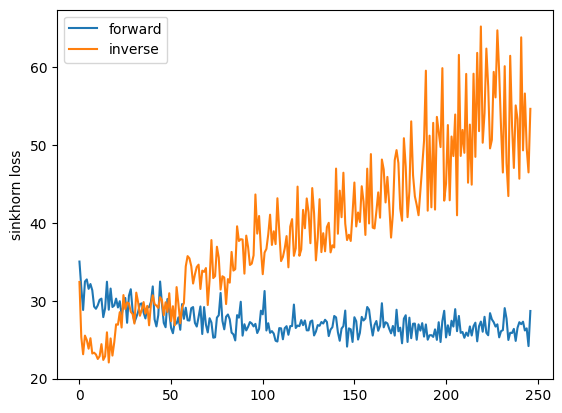

In [20]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

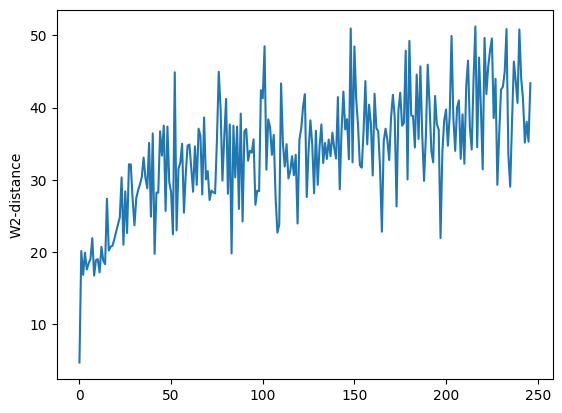

In [23]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

In [26]:
source = jnp.array(adata.obsm["X_pca"].copy())

In [27]:
velocity = tnp[14.5, 15.5].solution.push(source) - source

In [44]:
adata_result = AnnData(shape=velocity.shape)
adata_result.obs = adata.obs.copy()

In [45]:
adata_result.layers["GEX_velocity"] = np.asarray(velocity)
adata_result.layers["X_pca"] = np.asarray(adata.obsm["X_pca"])

In [46]:
adata_result

AnnData object with n_obs × n_vars = 16918 × 50
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'time'
    layers: 'GEX_velocity', 'X_pca'

In [ ]:
adata_result.write("/lustre/groups/ml01/workspace/monge_velo/multiome_pancreas/adata_gex_velocities.h5ad")